# Demo calculation of parallax and proper motion offset for a nearby star, making use of the Astropy libraries

In [18]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as c
import astropy.time

import astroquery.simbad # To install astroquery: $ conda install -c astropy astroquery

#### Plotting cosmetics

In [19]:
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['font.size'] = 20
#plt.style.use('dark_background')

%matplotlib inline

### Set star name and query SIMBAD database (requires internet connection)

In [22]:
star_name = "55 Cnc"

customSimbad = astroquery.simbad.Simbad()
customSimbad.add_votable_fields('sptype', 'flux(V)', 'pmra', 'pmdec', 'plx')
simbad_table = customSimbad.query_object(star_name)

### Get star's proper motion and parallax

In [24]:
pmra = simbad_table['PMRA'][0] * u.mas / u.yr
pmdec = simbad_table['PMDEC'][0] * u.mas / u.yr
plx = simbad_table['PLX_VALUE'][0] * u.mas
print(pmra, pmdec, plx)

-485.872 mas / yr -233.651 mas / yr 79.4274 mas


### Get star's coordinates

In [26]:
coord_j2000 = astropy.coordinates.SkyCoord.from_name(star_name)
print(coord_j2000.to_string('hmsdms'))

08h52m35.8113s +28d19m50.9569s


### Set time of first epoch and J2000 reference epoch

In [6]:
T_epoch1 = astropy.time.Time('2020-04-01T00:00:00', format='isot', scale='utc')
T_j2000 = astropy.time.Time('2000-01-01T00:00:00', format='isot', scale='utc')

In [28]:
time_span = 365 * u.day
time_samp = 1 * u.day

dates = T_epoch1 + np.arange(0, time_span.value, time_samp.value) * u.day

### Set the epoch of the second observation

In [30]:
T_epoch2 = T_epoch1 + 90 * u.day
t_ind_epoch2 = np.argmin(np.abs(T_epoch2 - dates))

### Apply proper motion to J2000 coordinates

In [32]:
coord_dec_epoch1 = coord_j2000.dec + (T_epoch1 - T_j2000) * pmdec
coord_ra_epoch1 = coord_j2000.ra + (T_epoch1 - T_j2000) * pmra / np.cos(coord_j2000.dec)

coord_epoch1 = astropy.coordinates.SkyCoord(
        frame='icrs', obstime=T_epoch1,
        ra = coord_ra_epoch1, dec = coord_dec_epoch1)

print(coord_epoch1.to_string('hmsdms'))

08h52m35.0662s +28d19m46.2257s


#### Sanity check

In [33]:
np.testing.assert_almost_equal(
        ((T_epoch1 - T_j2000).to(u.yr) * pmdec).to(u.arcsec).value,
        (coord_epoch1.dec - coord_j2000.dec).to(u.arcsec).value)

## Starting from first epoch, compute the parallax offsets in ecliptic coordinates for an array of dates. 

### We use the astropy.coordinates solar position lookup function to get the geocentric ecliptic coordinates of the Sun and the star at each date.

In [34]:
# Get geocentric ecliptic coordinates of Sun 
sun_loc = astropy.coordinates.get_sun(dates)
sun_skycoord = astropy.coordinates.SkyCoord(frame='gcrs', obstime=dates,
                                            ra = sun_loc.ra, dec = sun_loc.dec)
sun_eclon = sun_skycoord.geocentrictrueecliptic.lon
sun_eclat = sun_skycoord.geocentrictrueecliptic.lat

# Get geocentric ecliptic coordinates of star
star_eclon = coord_epoch1.geocentrictrueecliptic.lon
star_eclat = coord_epoch1.geocentrictrueecliptic.lat

# This is a low-precision approximation for the annual parallax offset.
# These forumlae assume the observer is geocentric. They ingore 
# the eccentricity of Earth's orbit, and the distinction between 
# the Sun and the Solar System barycenter.
# It is correct to within ~2% of the parallax amplitude.
# See, e.g., Chapter 8 of Spherical Astronomy by Robin M. Green for a derivation.
plx_delta_eclon = -plx * np.sin(star_eclon - sun_eclon) / np.cos(star_eclat)
plx_delta_eclat = -plx * np.cos(star_eclon - sun_eclon) * np.sin(star_eclat)

### Plot the parallax offset ellipse in ecliptic coordinates

#### Robin M. Green: "...the annual path of a star due to parallax is an ellipse of semimajor axis $\pi$, semiminor axis $\pi\sin\beta$, and therefore of eccentricity $\cos\beta$"

Text(0,0.5,'Ecliptic latitude offset (mas)')

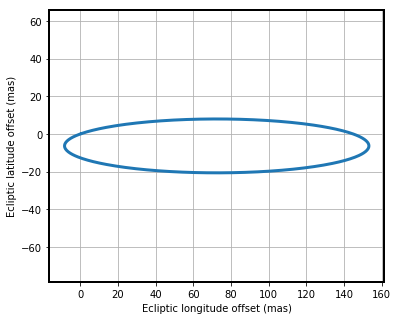

In [35]:
plt.figure(figsize=(6, 5))
plt.plot((plx_delta_eclon - plx_delta_eclon[0]).to(u.mas).value,
         (plx_delta_eclat - plx_delta_eclat[0]).to(u.mas).value)
plt.axis('equal')
plt.grid(True)
plt.xlabel('Ecliptic longitude offset (mas)')
plt.ylabel('Ecliptic latitude offset (mas)')

## Compute the parallax and proper motion offsets in equatorial coordinates

In [36]:
coord_plx = astropy.coordinates.GeocentricTrueEcliptic(
        lon = star_eclon + plx_delta_eclon,
        lat = star_eclat + plx_delta_eclat)
    
coord_plx_icrs = coord_plx.transform_to(astropy.coordinates.ICRS)

plx_delta_ra = coord_epoch1.spherical_offsets_to(coord_plx_icrs)[0]
plx_delta_dec = coord_epoch1.spherical_offsets_to(coord_plx_icrs)[1]

pm_delta_ra = pmra * (dates - T_epoch1)
pm_delta_dec = pmdec * (dates - T_epoch1)

pm_plx_delta_ra = plx_delta_ra + pm_delta_ra
pm_plx_delta_dec = plx_delta_dec + pm_delta_dec

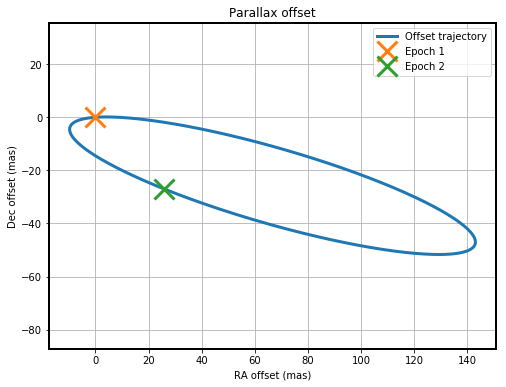

In [38]:
plt.figure(figsize=(8,6))
plt.title('Parallax offset')

plt.plot((plx_delta_ra - plx_delta_ra[0]).to(u.mas),
         (plx_delta_dec - plx_delta_dec[0]).to(u.mas))

plt.plot(0, 0, 'x', markersize=20, markeredgewidth=3)

plt.plot((plx_delta_ra[t_ind_epoch2] - plx_delta_ra[0]).to(u.mas),
         (plx_delta_dec[t_ind_epoch2] - plx_delta_dec[0]).to(u.mas),
         'x', markersize=20, markeredgewidth=3)

plt.axis('equal')
plt.grid(True)
plt.xlabel('RA offset (mas)')
plt.ylabel('Dec offset (mas)')
plt.legend(['Offset trajectory', 'Epoch 1', 'Epoch 2'])

### Plot the combined proper motion and parallax trajectory of the target star

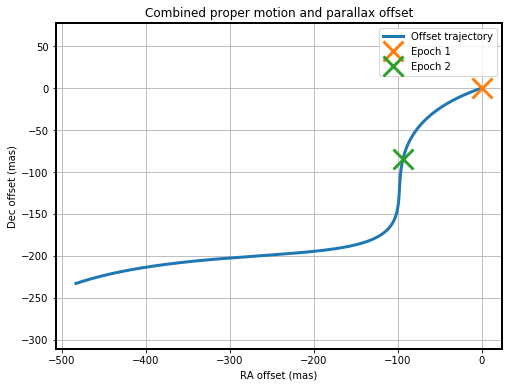

In [39]:
plt.figure(figsize=(8,6))
plt.title('Combined proper motion and parallax offset')
plt.plot((pm_plx_delta_ra - pm_plx_delta_ra[0]).to(u.mas),
         (pm_plx_delta_dec - pm_plx_delta_dec[0]).to(u.mas))

plt.plot(0, 0, 'x', markersize=20, markeredgewidth=3)

plt.plot((pm_plx_delta_ra[t_ind_epoch2] - pm_plx_delta_ra[0]).to(u.mas),
         (pm_plx_delta_dec[t_ind_epoch2] - pm_plx_delta_dec[0]).to(u.mas),
         'x', markersize=20, markeredgewidth=3)

plt.axis('equal')
plt.grid(True)
plt.xlabel('RA offset (mas)')
plt.ylabel('Dec offset (mas)')
plt.legend(['Offset trajectory', 'Epoch 1', 'Epoch 2'])

### This is the apparent motion of the target star between the two epochs. 

In [41]:
print('target star Delta RA: {:.2f}'.format(
        (pm_plx_delta_ra[t_ind_epoch2] - pm_plx_delta_ra[0]).to(u.mas)))
print('target star Delta Dec: {:.2f}'.format(
        (pm_plx_delta_dec[t_ind_epoch2]- pm_plx_delta_dec[0]).to(u.mas)))

target star Delta RA: -93.88 mas
target star Delta Dec: -84.56 mas
